In [21]:
%load_ext autoreload
%autoreload 2
# from google.colab import drive
# drive.mount('/content/gdrive')
import os
import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/Projects/2023-HJ-Prox/src/')


sys.path.append('/home/sh2146/pinns')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
# # cd/content/gdrive/My Drive/pinns
# cd/home/sh2146/pinns

In [23]:
import argparse
import torch
import torch.nn as nn
import data
import utils
# import importlib
# importlib.reload(utils)
import model
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

### 1. Default Setting

1. Domain: 100 x 256 ($x \in [-1,1]$ and $t \in [0,1]$)

2. Collocation points: $N_{ic}=256$ and $N_{f}=25600$

3. Optimizer: Adam with the learning rate of $10^{-3}$


In [24]:
num_t = 100
num_x = 256
num_epochs = 20000
num_hidden = 4
num_nodes = 128
lr = 1e-2

In [25]:
# Select a partial differential equation
# eq = 'ac'  or 'bg'
eq = 'bg'

### 2. Train Data

In [26]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
print("Operation mode: ", device)

Operation mode:  cuda:2


In [27]:
if eq == 'bg':
    t_data, x_data, u_data, t_data_f, x_data_f = data.bg_generator(num_t, num_x)  
elif eq == 'ac':
    t_data, x_data, u_data, t_data_f, x_data_f = data.ac_generator(num_t, num_x)
elif eq == 'hj':
    t_data, x_data, u_data, t_data_f, x_data_f = data.hj_generator(num_t, num_x)
else:
    print("There exists no the equation.")
    exit(0)
# print(eq)

In [28]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

### 3. Neural Network

In [29]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = model.pinn(layer_list).to(device)

/store/DAMTP/sh2146/mamba/envs/HJ/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


### 4. Training Session

In [30]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 1
bep = 0

In [31]:
for ep in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        
        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)
        
        if eq == 'bg':
            loss_f = torch.mean(utils.burgers_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'ac':
            loss_f = torch.mean(utils.ac_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'hj':
            loss_f = torch.mean(utils.hj_equation(u_hat_f, variables_f) ** 2)
        
        loss_u = torch.mean((u_hat - u_data) ** 2)
        loss = loss_f + loss_u
        loss.backward() 
        optimizer.step()
        
        l = loss.item()
        loss_graph.append(l)
        if l < ls:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_1d.pth')
            
        if ep % 1000 == 0:
            print(f"Train loss: {l}") 

  0%|          | 0/20000 [00:00<?, ?it/s]

Train loss: 0.9743964672088623


  5%|▌         | 1013/20000 [00:14<04:44, 66.67it/s]

Train loss: 0.8441962599754333


 10%|█         | 2007/20000 [00:29<04:36, 65.09it/s]

Train loss: 0.725277841091156


 15%|█▌        | 3011/20000 [00:44<04:03, 69.77it/s]

Train loss: 0.6975429654121399


 20%|██        | 4013/20000 [00:58<03:53, 68.59it/s]

Train loss: 0.6793593168258667


 25%|██▌       | 5007/20000 [01:13<03:35, 69.48it/s]

Train loss: 0.6739791631698608


 30%|███       | 6012/20000 [01:28<03:22, 69.14it/s]

Train loss: 0.6713231801986694


 35%|███▌      | 7011/20000 [01:42<03:12, 67.40it/s]

Train loss: 0.6684636473655701


 40%|████      | 8008/20000 [01:57<02:57, 67.63it/s]

Train loss: 0.6669378280639648


 45%|████▌     | 9013/20000 [02:12<02:46, 65.98it/s]

Train loss: 0.6658273339271545


 50%|█████     | 10009/20000 [02:27<02:31, 65.88it/s]

Train loss: 0.664892315864563


 55%|█████▌    | 11013/20000 [02:42<02:18, 64.84it/s]

Train loss: 0.6643342971801758


 60%|██████    | 12010/20000 [02:57<02:00, 66.51it/s]

Train loss: 0.6640079617500305


 65%|██████▌   | 13008/20000 [03:14<02:00, 57.85it/s]

Train loss: 0.6545211672782898


 70%|███████   | 14008/20000 [03:31<01:37, 61.69it/s]

Train loss: 0.625670313835144


 75%|███████▌  | 15013/20000 [03:46<01:20, 62.01it/s]

Train loss: 0.6117153167724609


 80%|████████  | 16010/20000 [04:01<00:58, 67.98it/s]

Train loss: 0.6093525290489197


 85%|████████▌ | 17011/20000 [04:16<00:44, 66.47it/s]

Train loss: 0.6078509092330933


 90%|█████████ | 18010/20000 [04:31<00:28, 70.85it/s]

Train loss: 0.6073932647705078


 95%|█████████▌| 19011/20000 [04:45<00:14, 69.51it/s]

Train loss: 0.607052743434906


100%|██████████| 20000/20000 [05:00<00:00, 66.58it/s]


[Best][Epoch: 19980] Train loss: 0.6066364645957947


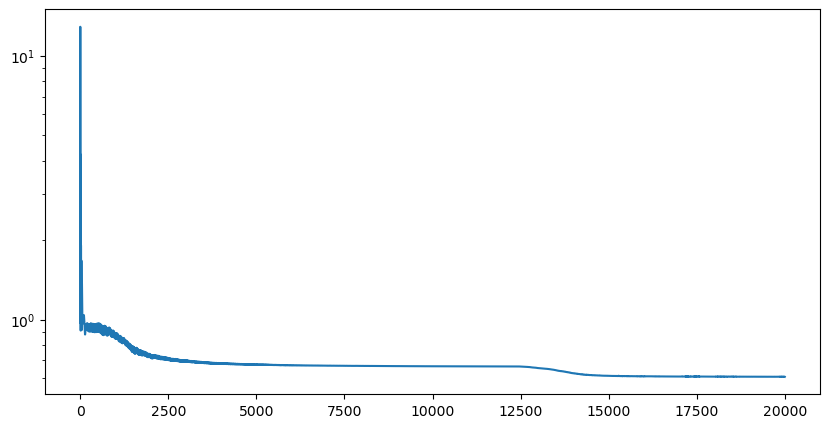

In [32]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}") 
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.yscale('log')
plt.show()

### 5. Inference Session

In [33]:
pinn.load_state_dict(torch.load('./'+eq+'_1d.pth'))

<All keys matched successfully>

In [34]:
def ic(x,y):
    f = torch.zeros(256, 101)
    for j in range(len(y)):
        for i in range(len(x)):
                f[i,j] = x[i]**2/(2*y[j]+1)
    return f
        

interval_x = torch.arange(-1,1, 2/256)
# #print(interval_x)
interval_t = torch.arange(0,1, 1/100)
# #print(interval_t)

# interval = torch.stack((interval_x, interval_t), 1)
# print(interval)

#interval = torch.cartesian_prod(interval_x, interval_t)
#print(interval[0, 1])

#data = torch.tensor(list(map(f, interval_x, interval_t)))



In [35]:
if eq == 'hj':       
    t_test, x_test = data.hj_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)
    print(u_pred.shape)
    # reference data
    d = ic(interval_x, interval_t)
    # Exact = np.real(data['usol']) 
    Exact = d.cpu().numpy().reshape(N,T)
    print(Exact.shape)
    # data = scipy.io.loadmat('./data/burgers_shock.mat')  
    # Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact[:,:-1]
    
    
    

if eq == 'bg':       
    t_test, x_test = data.bg_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/burgers_shock.mat')  
    Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact
    
elif eq == 'ac':
    t = np.linspace(0, 1, 201).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, 513)[:-1].reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    t_test = T_star.flatten()[:, None]
    x_test = X_star.flatten()[:, None]
    
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/AC.mat')
    Exact = np.real(data['uu'])
    err = u_pred-Exact

err = np.linalg.norm(err,2)/np.linalg.norm(Exact,2)   
print(f"L2 Relative Error: {err}")

L2 Relative Error: 1.1181128373495242


### 6. Result Figures

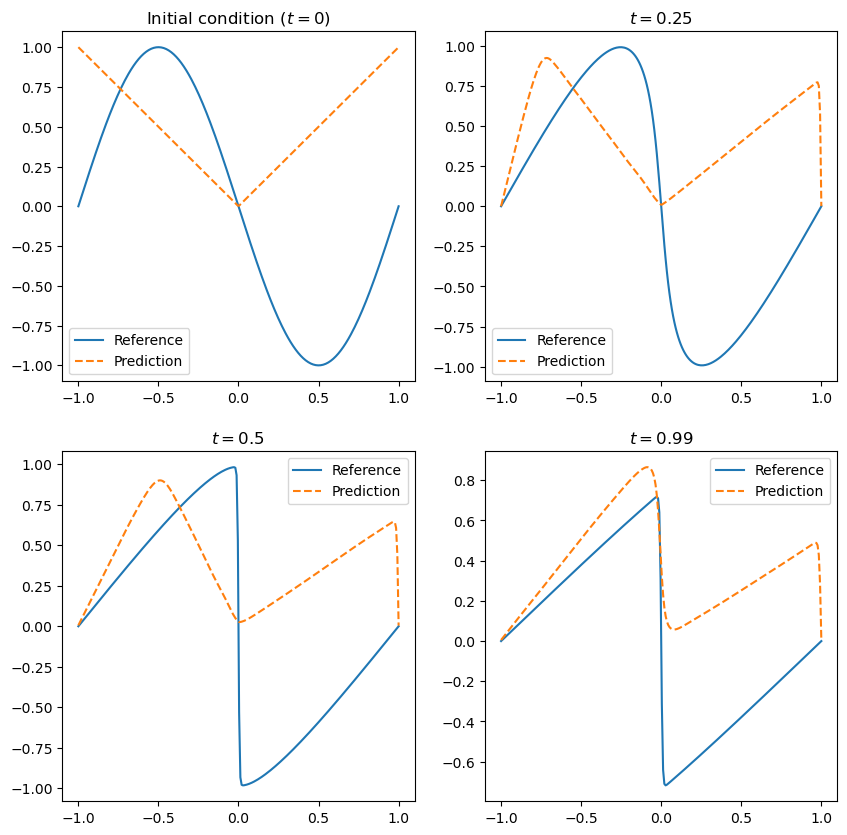

In [36]:
utils.resplot(x, t, t_data, x_data, Exact, u_pred)

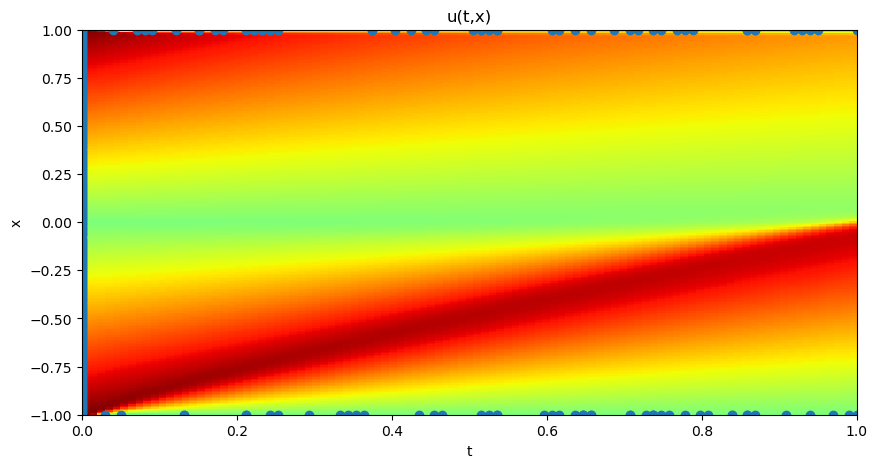

In [37]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
plt.clim(-1, 1)
plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()